In [1]:
%matplotlib notebook

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torchvision.utils import make_grid
import torch.nn as nn
from time import time as time
import cv2

import PIL

import numpy as np
from matplotlib import pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# DCGAN rules!
Training info: 150 epochs and 105.522 images (trained model can be found at /models/trained.pt) <br>
The whole training process can be described as following: <br>
1) 0-10 epochs. Training classical DCGAN <br>
2) 10+ epochs. <br>
Gaussian noise was added to Discriminator inputs (to slow down it's progress). <br>
I also used label smoothing as described in papers like (Salimans et. al. 2016), but reducing them by $|N(0, 1)|$-distributed random variable.<br>
And the last thing is adding MAE term to G's loss: <br>
$$\mathcal{L}'_G = \mathcal{L}_G + \lambda*\mu(|img - \gamma|),$$ <br>where $\mu(X)$ represents element-wise mean for tensor $X$ (scalar value), $\gamma$ is an optimal brightness value of each pixel in each channel (subtraction and abs. are element-wise here) and $\lambda$ is a hyperparameter. $\gamma$ was counted as a mean value for training dataset. The second term is a penalty for generating too bright or too dark images. <br>
3) Some of the above additions may have been disabled depending on the progress of D and G


In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
dataroot = "./Data/Faces/biggerset/"

image_size = 64
workers = 2
batch_size = 64

num_epochs = 150
lr = 0.0002
beta1 = 0.5

In [6]:
dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.RandomHorizontalFlip(0.5),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


<IPython.core.display.Javascript object>


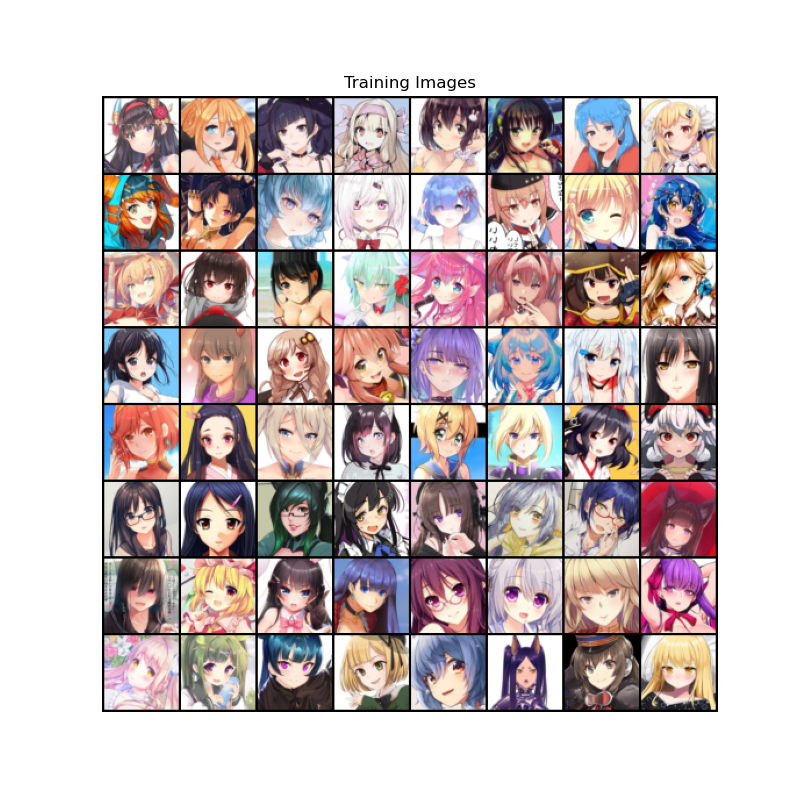

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
channels = 3
noise_len = 100
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_len , 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64 * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 1, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netG = Generator().to(device)
netG.apply(weights_init)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64 * 1, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 1, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = Discriminator().to(device)
netD.apply(weights_init)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [40]:
#can be used if your dataset has a lot of dark or bright images (dark colours penalty)
#another loss function in training loop should be uncommented then

best_balance_mean = 0.825 #estimation got from the dataset

def gen_penalty(generated):
    penalty_cost = 0.0
    for img in generated:
        penalty_cost += (1 - torch.mean(img))
    return torch.abs(penalty_cost / len(generated) - best_balance_mean)

In [14]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
#lmbd = 2.5

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        #Gaussian noise for real data
        real_cpu = data[0].to(device) + (torch.randn(data[0].shape[0], 3, 64, 64)).to(device)*0.025
        b_size = real_cpu.size(0)
        #label smoothing with abs(normal distributed noise) (up to 0.2 from exact unit)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device) - torch.abs(torch.randn(b_size, device=device)/5)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        #penalty = gen_penalty(fake)
        #errG = criterion(output, label) + penalty * lmbd
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))
        
    if (not epoch % 10) and (epoch > 0):
        print(f"Saving progress at biggererset_{epoch}.pt")
        torch.save(netG.state_dict(), f"./models/biggererset_{epoch}_G.pt")
        torch.save(netD.state_dict(), f"./models/biggererset_{epoch}_D.pt")

Starting Training Loop...
[0/100][0/1649]	Loss_D: 0.5762	Loss_G: 6.5720	
[0/100][50/1649]	Loss_D: 0.5456	Loss_G: 2.5835	
[0/100][100/1649]	Loss_D: 0.5687	Loss_G: 4.3173	
[0/100][150/1649]	Loss_D: 0.4662	Loss_G: 5.6362	
[0/100][200/1649]	Loss_D: 0.4743	Loss_G: 4.5688	
[0/100][250/1649]	Loss_D: 0.5357	Loss_G: 5.1117	
[0/100][300/1649]	Loss_D: 0.5354	Loss_G: 4.2864	
[0/100][350/1649]	Loss_D: 0.4823	Loss_G: 4.5692	
[0/100][400/1649]	Loss_D: 0.5293	Loss_G: 3.9412	
[0/100][450/1649]	Loss_D: 0.5532	Loss_G: 3.7050	
[0/100][500/1649]	Loss_D: 0.7495	Loss_G: 2.4354	
[0/100][550/1649]	Loss_D: 0.5294	Loss_G: 3.0807	
[0/100][600/1649]	Loss_D: 0.5585	Loss_G: 3.3986	
[0/100][650/1649]	Loss_D: 0.5534	Loss_G: 3.1258	
[0/100][700/1649]	Loss_D: 0.5800	Loss_G: 4.0378	
[0/100][750/1649]	Loss_D: 0.5477	Loss_G: 3.6071	
[0/100][800/1649]	Loss_D: 0.5177	Loss_G: 4.2388	
[0/100][850/1649]	Loss_D: 0.4601	Loss_G: 3.8985	
[0/100][900/1649]	Loss_D: 0.4635	Loss_G: 4.5105	
[0/100][950/1649]	Loss_D: 0.5647	Loss_G: 4.131

[5/100][50/1649]	Loss_D: 0.6897	Loss_G: 3.6817	
[5/100][100/1649]	Loss_D: 0.5160	Loss_G: 4.0440	
[5/100][150/1649]	Loss_D: 0.5763	Loss_G: 5.1886	
[5/100][200/1649]	Loss_D: 0.4591	Loss_G: 4.5584	
[5/100][250/1649]	Loss_D: 0.5722	Loss_G: 3.9509	
[5/100][300/1649]	Loss_D: 0.5012	Loss_G: 4.4386	
[5/100][350/1649]	Loss_D: 0.4966	Loss_G: 3.7031	
[5/100][400/1649]	Loss_D: 0.5497	Loss_G: 4.5724	
[5/100][450/1649]	Loss_D: 0.5607	Loss_G: 3.4500	
[5/100][500/1649]	Loss_D: 0.5334	Loss_G: 3.7172	
[5/100][550/1649]	Loss_D: 0.5061	Loss_G: 4.5242	
[5/100][600/1649]	Loss_D: 0.4868	Loss_G: 4.7835	
[5/100][650/1649]	Loss_D: 0.4895	Loss_G: 4.8402	
[5/100][700/1649]	Loss_D: 0.5802	Loss_G: 3.2356	
[5/100][750/1649]	Loss_D: 0.5777	Loss_G: 3.1478	
[5/100][800/1649]	Loss_D: 0.5337	Loss_G: 4.9928	
[5/100][850/1649]	Loss_D: 0.5520	Loss_G: 3.2608	
[5/100][900/1649]	Loss_D: 0.4943	Loss_G: 4.8601	
[5/100][950/1649]	Loss_D: 0.5461	Loss_G: 3.8448	
[5/100][1000/1649]	Loss_D: 0.5101	Loss_G: 4.3790	
[5/100][1050/1649]	L

[10/100][150/1649]	Loss_D: 0.5100	Loss_G: 4.8943	
[10/100][200/1649]	Loss_D: 0.5291	Loss_G: 3.7911	
[10/100][250/1649]	Loss_D: 0.5196	Loss_G: 4.5755	
[10/100][300/1649]	Loss_D: 0.5031	Loss_G: 5.0032	
[10/100][350/1649]	Loss_D: 0.5241	Loss_G: 4.8330	
[10/100][400/1649]	Loss_D: 0.5848	Loss_G: 3.9544	
[10/100][450/1649]	Loss_D: 0.4997	Loss_G: 4.5322	
[10/100][500/1649]	Loss_D: 0.5568	Loss_G: 5.1311	
[10/100][550/1649]	Loss_D: 0.6496	Loss_G: 3.2465	
[10/100][600/1649]	Loss_D: 0.5260	Loss_G: 5.0407	
[10/100][650/1649]	Loss_D: 0.4781	Loss_G: 3.9164	
[10/100][700/1649]	Loss_D: 0.4379	Loss_G: 3.5878	
[10/100][750/1649]	Loss_D: 0.9612	Loss_G: 5.4129	
[10/100][800/1649]	Loss_D: 0.4964	Loss_G: 3.9310	
[10/100][850/1649]	Loss_D: 0.4708	Loss_G: 4.3001	
[10/100][900/1649]	Loss_D: 0.5561	Loss_G: 3.5097	
[10/100][950/1649]	Loss_D: 0.4811	Loss_G: 4.9549	
[10/100][1000/1649]	Loss_D: 0.5140	Loss_G: 3.7467	
[10/100][1050/1649]	Loss_D: 0.5159	Loss_G: 4.0634	
[10/100][1100/1649]	Loss_D: 0.4941	Loss_G: 5.069

[15/100][50/1649]	Loss_D: 0.5200	Loss_G: 5.3096	
[15/100][100/1649]	Loss_D: 0.4617	Loss_G: 5.3353	
[15/100][150/1649]	Loss_D: 0.5530	Loss_G: 3.9470	
[15/100][200/1649]	Loss_D: 0.5854	Loss_G: 2.3564	
[15/100][250/1649]	Loss_D: 0.5202	Loss_G: 5.0656	
[15/100][300/1649]	Loss_D: 0.5153	Loss_G: 4.6843	
[15/100][350/1649]	Loss_D: 0.7434	Loss_G: 4.4823	
[15/100][400/1649]	Loss_D: 0.5577	Loss_G: 4.3596	
[15/100][450/1649]	Loss_D: 0.7218	Loss_G: 2.3170	
[15/100][500/1649]	Loss_D: 0.5132	Loss_G: 3.8307	
[15/100][550/1649]	Loss_D: 0.5357	Loss_G: 4.8906	
[15/100][600/1649]	Loss_D: 0.5126	Loss_G: 4.9099	
[15/100][650/1649]	Loss_D: 0.5179	Loss_G: 3.6026	
[15/100][700/1649]	Loss_D: 0.5295	Loss_G: 4.6401	
[15/100][750/1649]	Loss_D: 0.5104	Loss_G: 4.1407	
[15/100][800/1649]	Loss_D: 0.5294	Loss_G: 4.1464	
[15/100][850/1649]	Loss_D: 0.4738	Loss_G: 4.3341	
[15/100][900/1649]	Loss_D: 0.6884	Loss_G: 4.5723	
[15/100][950/1649]	Loss_D: 0.6702	Loss_G: 3.3182	
[15/100][1000/1649]	Loss_D: 0.5635	Loss_G: 3.7324	


[19/100][1600/1649]	Loss_D: 0.5126	Loss_G: 4.1961	
[20/100][0/1649]	Loss_D: 0.5325	Loss_G: 3.5269	
[20/100][50/1649]	Loss_D: 0.4765	Loss_G: 5.1537	
[20/100][100/1649]	Loss_D: 0.5331	Loss_G: 3.2965	
[20/100][150/1649]	Loss_D: 0.5250	Loss_G: 4.3995	
[20/100][200/1649]	Loss_D: 0.5203	Loss_G: 3.6909	
[20/100][250/1649]	Loss_D: 0.5188	Loss_G: 5.4954	
[20/100][300/1649]	Loss_D: 0.4971	Loss_G: 5.0244	
[20/100][350/1649]	Loss_D: 0.5509	Loss_G: 2.9498	
[20/100][400/1649]	Loss_D: 0.5489	Loss_G: 4.2239	
[20/100][450/1649]	Loss_D: 0.6111	Loss_G: 3.5725	
[20/100][500/1649]	Loss_D: 0.4940	Loss_G: 5.2046	
[20/100][550/1649]	Loss_D: 0.5589	Loss_G: 3.0201	
[20/100][600/1649]	Loss_D: 0.4903	Loss_G: 4.5195	
[20/100][650/1649]	Loss_D: 0.5267	Loss_G: 4.6197	
[20/100][700/1649]	Loss_D: 0.5193	Loss_G: 2.9576	
[20/100][750/1649]	Loss_D: 0.5360	Loss_G: 4.9537	
[20/100][800/1649]	Loss_D: 0.4678	Loss_G: 4.3087	
[20/100][850/1649]	Loss_D: 0.4912	Loss_G: 4.6103	
[20/100][900/1649]	Loss_D: 0.4855	Loss_G: 4.1360	
[2

[24/100][1500/1649]	Loss_D: 0.5088	Loss_G: 4.3528	
[24/100][1550/1649]	Loss_D: 0.5462	Loss_G: 5.6022	
[24/100][1600/1649]	Loss_D: 0.5736	Loss_G: 4.4135	
[25/100][0/1649]	Loss_D: 0.5299	Loss_G: 3.9189	
[25/100][50/1649]	Loss_D: 0.5040	Loss_G: 4.4121	
[25/100][100/1649]	Loss_D: 0.5326	Loss_G: 3.4251	
[25/100][150/1649]	Loss_D: 0.4497	Loss_G: 4.8850	
[25/100][200/1649]	Loss_D: 0.6393	Loss_G: 2.6860	
[25/100][250/1649]	Loss_D: 0.5587	Loss_G: 3.6634	
[25/100][300/1649]	Loss_D: 0.5661	Loss_G: 5.2380	
[25/100][350/1649]	Loss_D: 0.5293	Loss_G: 4.1197	
[25/100][400/1649]	Loss_D: 0.5219	Loss_G: 4.1884	
[25/100][450/1649]	Loss_D: 0.5401	Loss_G: 5.1771	
[25/100][500/1649]	Loss_D: 0.5313	Loss_G: 4.7928	
[25/100][550/1649]	Loss_D: 0.4817	Loss_G: 3.0836	
[25/100][600/1649]	Loss_D: 0.5428	Loss_G: 5.3655	
[25/100][650/1649]	Loss_D: 0.4597	Loss_G: 5.1580	
[25/100][700/1649]	Loss_D: 0.5990	Loss_G: 3.2500	
[25/100][750/1649]	Loss_D: 0.4925	Loss_G: 4.4048	
[25/100][800/1649]	Loss_D: 0.4816	Loss_G: 5.1330	


[29/100][1400/1649]	Loss_D: 0.4765	Loss_G: 4.9181	
[29/100][1450/1649]	Loss_D: 0.5105	Loss_G: 3.5993	
[29/100][1500/1649]	Loss_D: 0.4646	Loss_G: 5.2423	
[29/100][1550/1649]	Loss_D: 0.8151	Loss_G: 1.6201	
[29/100][1600/1649]	Loss_D: 0.4491	Loss_G: 4.2370	
[30/100][0/1649]	Loss_D: 0.6422	Loss_G: 5.4109	
[30/100][50/1649]	Loss_D: 0.5627	Loss_G: 3.8776	
[30/100][100/1649]	Loss_D: 0.4847	Loss_G: 5.1284	
[30/100][150/1649]	Loss_D: 0.5282	Loss_G: 5.3296	
[30/100][200/1649]	Loss_D: 0.4966	Loss_G: 3.9640	
[30/100][250/1649]	Loss_D: 0.5155	Loss_G: 4.1774	
[30/100][300/1649]	Loss_D: 0.4471	Loss_G: 3.8334	
[30/100][350/1649]	Loss_D: 0.5602	Loss_G: 3.5823	
[30/100][400/1649]	Loss_D: 0.5157	Loss_G: 4.1512	
[30/100][450/1649]	Loss_D: 0.5025	Loss_G: 4.5461	
[30/100][500/1649]	Loss_D: 0.5472	Loss_G: 4.3627	
[30/100][550/1649]	Loss_D: 0.4906	Loss_G: 4.4165	
[30/100][600/1649]	Loss_D: 0.6081	Loss_G: 3.5605	
[30/100][650/1649]	Loss_D: 0.4981	Loss_G: 4.4371	
[30/100][700/1649]	Loss_D: 0.5537	Loss_G: 2.5238

[34/100][1300/1649]	Loss_D: 0.5156	Loss_G: 3.9532	
[34/100][1350/1649]	Loss_D: 0.4747	Loss_G: 5.4898	
[34/100][1400/1649]	Loss_D: 0.4756	Loss_G: 5.3187	
[34/100][1450/1649]	Loss_D: 0.4563	Loss_G: 4.2813	
[34/100][1500/1649]	Loss_D: 0.4878	Loss_G: 4.5885	
[34/100][1550/1649]	Loss_D: 0.5152	Loss_G: 4.8795	
[34/100][1600/1649]	Loss_D: 0.4569	Loss_G: 4.5346	
[35/100][0/1649]	Loss_D: 0.5242	Loss_G: 5.1265	
[35/100][50/1649]	Loss_D: 0.4624	Loss_G: 3.8711	
[35/100][100/1649]	Loss_D: 0.5174	Loss_G: 3.6496	
[35/100][150/1649]	Loss_D: 0.5244	Loss_G: 5.2275	
[35/100][200/1649]	Loss_D: 0.4875	Loss_G: 3.4336	
[35/100][250/1649]	Loss_D: 0.4912	Loss_G: 4.4088	
[35/100][300/1649]	Loss_D: 0.4972	Loss_G: 4.2584	
[35/100][350/1649]	Loss_D: 0.5236	Loss_G: 5.7753	
[35/100][400/1649]	Loss_D: 0.5259	Loss_G: 5.3812	
[35/100][450/1649]	Loss_D: 0.5374	Loss_G: 3.4831	
[35/100][500/1649]	Loss_D: 0.5177	Loss_G: 4.6700	
[35/100][550/1649]	Loss_D: 0.6371	Loss_G: 4.1919	
[35/100][600/1649]	Loss_D: 0.5127	Loss_G: 3.60

[39/100][1200/1649]	Loss_D: 0.4873	Loss_G: 4.2376	
[39/100][1250/1649]	Loss_D: 0.5174	Loss_G: 3.8817	
[39/100][1300/1649]	Loss_D: 0.5377	Loss_G: 3.4297	
[39/100][1350/1649]	Loss_D: 0.4486	Loss_G: 3.5089	
[39/100][1400/1649]	Loss_D: 0.5170	Loss_G: 5.1294	
[39/100][1450/1649]	Loss_D: 0.4725	Loss_G: 5.5963	
[39/100][1500/1649]	Loss_D: 0.4568	Loss_G: 4.5642	
[39/100][1550/1649]	Loss_D: 0.5531	Loss_G: 4.7308	
[39/100][1600/1649]	Loss_D: 0.5669	Loss_G: 4.9721	
[40/100][0/1649]	Loss_D: 0.6833	Loss_G: 4.7542	
[40/100][50/1649]	Loss_D: 0.5340	Loss_G: 5.1001	
[40/100][100/1649]	Loss_D: 0.5087	Loss_G: 4.7653	
[40/100][150/1649]	Loss_D: 0.5193	Loss_G: 3.8279	
[40/100][200/1649]	Loss_D: 0.5027	Loss_G: 4.8568	
[40/100][250/1649]	Loss_D: 0.5393	Loss_G: 3.2766	
[40/100][300/1649]	Loss_D: 0.5072	Loss_G: 5.5581	
[40/100][350/1649]	Loss_D: 0.4643	Loss_G: 5.1864	
[40/100][400/1649]	Loss_D: 0.4864	Loss_G: 4.0451	
[40/100][450/1649]	Loss_D: 0.5515	Loss_G: 5.1331	
[40/100][500/1649]	Loss_D: 0.5790	Loss_G: 5.

[44/100][1100/1649]	Loss_D: 0.4853	Loss_G: 4.4158	
[44/100][1150/1649]	Loss_D: 0.5095	Loss_G: 3.3872	
[44/100][1200/1649]	Loss_D: 0.8458	Loss_G: 1.9918	
[44/100][1250/1649]	Loss_D: 0.4719	Loss_G: 4.5647	
[44/100][1300/1649]	Loss_D: 0.4473	Loss_G: 3.6721	
[44/100][1350/1649]	Loss_D: 0.5758	Loss_G: 5.7611	
[44/100][1400/1649]	Loss_D: 0.5064	Loss_G: 3.9694	
[44/100][1450/1649]	Loss_D: 0.4634	Loss_G: 4.7374	
[44/100][1500/1649]	Loss_D: 0.5169	Loss_G: 4.0938	
[44/100][1550/1649]	Loss_D: 0.5603	Loss_G: 4.3930	
[44/100][1600/1649]	Loss_D: 0.5460	Loss_G: 3.5164	
[45/100][0/1649]	Loss_D: 0.5350	Loss_G: 5.3647	
[45/100][50/1649]	Loss_D: 0.4746	Loss_G: 5.0319	
[45/100][100/1649]	Loss_D: 0.4930	Loss_G: 4.6408	
[45/100][150/1649]	Loss_D: 0.8613	Loss_G: 3.1644	
[45/100][200/1649]	Loss_D: 0.5034	Loss_G: 4.7192	
[45/100][250/1649]	Loss_D: 0.4495	Loss_G: 3.4100	
[45/100][300/1649]	Loss_D: 0.5137	Loss_G: 3.9920	
[45/100][350/1649]	Loss_D: 0.4852	Loss_G: 4.5922	
[45/100][400/1649]	Loss_D: 0.5042	Loss_G: 

[49/100][1000/1649]	Loss_D: 0.5495	Loss_G: 4.6177	
[49/100][1050/1649]	Loss_D: 0.5528	Loss_G: 4.8036	
[49/100][1100/1649]	Loss_D: 0.5018	Loss_G: 5.2047	
[49/100][1150/1649]	Loss_D: 0.4869	Loss_G: 5.0578	
[49/100][1200/1649]	Loss_D: 0.4636	Loss_G: 3.7103	
[49/100][1250/1649]	Loss_D: 0.4598	Loss_G: 4.9769	
[49/100][1300/1649]	Loss_D: 0.4958	Loss_G: 3.8699	
[49/100][1350/1649]	Loss_D: 0.4956	Loss_G: 4.2887	
[49/100][1400/1649]	Loss_D: 0.5473	Loss_G: 4.2116	
[49/100][1450/1649]	Loss_D: 0.4909	Loss_G: 3.3231	
[49/100][1500/1649]	Loss_D: 0.5102	Loss_G: 2.4505	
[49/100][1550/1649]	Loss_D: 0.4663	Loss_G: 5.0052	
[49/100][1600/1649]	Loss_D: 0.4544	Loss_G: 5.0171	
[50/100][0/1649]	Loss_D: 0.5547	Loss_G: 4.1752	
[50/100][50/1649]	Loss_D: 0.4908	Loss_G: 4.6514	
[50/100][100/1649]	Loss_D: 0.5557	Loss_G: 5.3654	
[50/100][150/1649]	Loss_D: 0.5296	Loss_G: 5.0221	
[50/100][200/1649]	Loss_D: 0.5035	Loss_G: 3.9997	
[50/100][250/1649]	Loss_D: 0.6197	Loss_G: 4.3591	
[50/100][300/1649]	Loss_D: 0.5636	Loss_G

[54/100][900/1649]	Loss_D: 0.4739	Loss_G: 4.8121	
[54/100][950/1649]	Loss_D: 0.5198	Loss_G: 4.3738	
[54/100][1000/1649]	Loss_D: 0.4546	Loss_G: 4.5894	
[54/100][1050/1649]	Loss_D: 0.7205	Loss_G: 3.1394	
[54/100][1100/1649]	Loss_D: 0.5078	Loss_G: 5.6053	
[54/100][1150/1649]	Loss_D: 0.5078	Loss_G: 4.0735	
[54/100][1200/1649]	Loss_D: 0.4778	Loss_G: 4.3575	
[54/100][1250/1649]	Loss_D: 0.5163	Loss_G: 5.7814	
[54/100][1300/1649]	Loss_D: 0.5123	Loss_G: 4.5050	
[54/100][1350/1649]	Loss_D: 0.5261	Loss_G: 4.3766	
[54/100][1400/1649]	Loss_D: 0.6021	Loss_G: 4.1458	
[54/100][1450/1649]	Loss_D: 0.4753	Loss_G: 3.5627	
[54/100][1500/1649]	Loss_D: 0.5981	Loss_G: 4.7173	
[54/100][1550/1649]	Loss_D: 0.4658	Loss_G: 4.3822	
[54/100][1600/1649]	Loss_D: 0.4736	Loss_G: 4.3493	
[55/100][0/1649]	Loss_D: 0.4779	Loss_G: 5.0346	
[55/100][50/1649]	Loss_D: 0.6658	Loss_G: 4.3848	
[55/100][100/1649]	Loss_D: 0.6026	Loss_G: 3.0785	
[55/100][150/1649]	Loss_D: 0.5093	Loss_G: 3.7890	
[55/100][200/1649]	Loss_D: 0.4911	Loss_G

[59/100][800/1649]	Loss_D: 0.5343	Loss_G: 5.0819	
[59/100][850/1649]	Loss_D: 0.4696	Loss_G: 4.5881	
[59/100][900/1649]	Loss_D: 0.5007	Loss_G: 5.1706	
[59/100][950/1649]	Loss_D: 0.5296	Loss_G: 5.1760	
[59/100][1000/1649]	Loss_D: 0.5193	Loss_G: 5.6011	
[59/100][1050/1649]	Loss_D: 0.5222	Loss_G: 4.8259	
[59/100][1100/1649]	Loss_D: 0.4598	Loss_G: 5.2331	
[59/100][1150/1649]	Loss_D: 0.5040	Loss_G: 3.9264	
[59/100][1200/1649]	Loss_D: 0.5122	Loss_G: 4.7483	
[59/100][1250/1649]	Loss_D: 0.4642	Loss_G: 4.5913	
[59/100][1300/1649]	Loss_D: 0.4750	Loss_G: 4.5363	
[59/100][1350/1649]	Loss_D: 0.5184	Loss_G: 3.3986	
[59/100][1400/1649]	Loss_D: 0.5688	Loss_G: 3.5632	
[59/100][1450/1649]	Loss_D: 0.5503	Loss_G: 4.4015	
[59/100][1500/1649]	Loss_D: 0.4945	Loss_G: 4.8981	
[59/100][1550/1649]	Loss_D: 0.4766	Loss_G: 4.0653	
[59/100][1600/1649]	Loss_D: 0.4771	Loss_G: 5.4682	
[60/100][0/1649]	Loss_D: 0.5349	Loss_G: 4.6756	
[60/100][50/1649]	Loss_D: 0.5618	Loss_G: 4.4239	
[60/100][100/1649]	Loss_D: 0.5276	Loss_G

[64/100][700/1649]	Loss_D: 0.4727	Loss_G: 4.9892	
[64/100][750/1649]	Loss_D: 0.4653	Loss_G: 4.4957	
[64/100][800/1649]	Loss_D: 0.4833	Loss_G: 4.1916	
[64/100][850/1649]	Loss_D: 0.4760	Loss_G: 4.7706	
[64/100][900/1649]	Loss_D: 0.5519	Loss_G: 4.3456	
[64/100][950/1649]	Loss_D: 0.4735	Loss_G: 4.3058	
[64/100][1000/1649]	Loss_D: 0.5627	Loss_G: 3.7828	
[64/100][1050/1649]	Loss_D: 0.5215	Loss_G: 4.3687	
[64/100][1100/1649]	Loss_D: 0.5579	Loss_G: 4.8920	
[64/100][1150/1649]	Loss_D: 0.8530	Loss_G: 2.1676	
[64/100][1200/1649]	Loss_D: 0.5052	Loss_G: 4.1328	
[64/100][1250/1649]	Loss_D: 0.5153	Loss_G: 3.2407	
[64/100][1300/1649]	Loss_D: 0.5407	Loss_G: 4.1963	
[64/100][1350/1649]	Loss_D: 0.4857	Loss_G: 3.5290	
[64/100][1400/1649]	Loss_D: 0.4821	Loss_G: 6.1549	
[64/100][1450/1649]	Loss_D: 0.4955	Loss_G: 3.9590	
[64/100][1500/1649]	Loss_D: 0.6634	Loss_G: 3.2758	
[64/100][1550/1649]	Loss_D: 0.4716	Loss_G: 3.8398	
[64/100][1600/1649]	Loss_D: 0.4911	Loss_G: 4.1757	
[65/100][0/1649]	Loss_D: 0.5363	Loss_

[69/100][600/1649]	Loss_D: 0.5705	Loss_G: 3.2413	
[69/100][650/1649]	Loss_D: 0.4907	Loss_G: 4.4057	
[69/100][700/1649]	Loss_D: 0.7588	Loss_G: 4.1078	
[69/100][750/1649]	Loss_D: 0.5720	Loss_G: 4.8004	
[69/100][800/1649]	Loss_D: 0.5079	Loss_G: 3.9495	
[69/100][850/1649]	Loss_D: 0.4957	Loss_G: 3.7592	
[69/100][900/1649]	Loss_D: 0.4680	Loss_G: 4.1092	
[69/100][950/1649]	Loss_D: 0.4978	Loss_G: 5.2138	
[69/100][1000/1649]	Loss_D: 0.5806	Loss_G: 2.6186	
[69/100][1050/1649]	Loss_D: 0.5202	Loss_G: 5.5760	
[69/100][1100/1649]	Loss_D: 1.0415	Loss_G: 2.8367	
[69/100][1150/1649]	Loss_D: 0.5684	Loss_G: 3.9064	
[69/100][1200/1649]	Loss_D: 0.5144	Loss_G: 4.6615	
[69/100][1250/1649]	Loss_D: 0.5156	Loss_G: 5.0261	
[69/100][1300/1649]	Loss_D: 0.4953	Loss_G: 5.7400	
[69/100][1350/1649]	Loss_D: 0.5312	Loss_G: 3.6393	
[69/100][1400/1649]	Loss_D: 0.4849	Loss_G: 5.4644	
[69/100][1450/1649]	Loss_D: 0.5363	Loss_G: 3.7029	
[69/100][1500/1649]	Loss_D: 0.5494	Loss_G: 4.4479	
[69/100][1550/1649]	Loss_D: 0.4640	Loss

[74/100][500/1649]	Loss_D: 0.5338	Loss_G: 4.5171	
[74/100][550/1649]	Loss_D: 0.5334	Loss_G: 4.1876	
[74/100][600/1649]	Loss_D: 0.4573	Loss_G: 4.2930	
[74/100][650/1649]	Loss_D: 0.7268	Loss_G: 4.4180	
[74/100][700/1649]	Loss_D: 0.5281	Loss_G: 5.4723	
[74/100][750/1649]	Loss_D: 0.5071	Loss_G: 4.1921	
[74/100][800/1649]	Loss_D: 0.4949	Loss_G: 5.1149	
[74/100][850/1649]	Loss_D: 0.5396	Loss_G: 3.7313	
[74/100][900/1649]	Loss_D: 0.5381	Loss_G: 5.0817	
[74/100][950/1649]	Loss_D: 0.5408	Loss_G: 3.9984	
[74/100][1000/1649]	Loss_D: 0.5424	Loss_G: 5.9475	
[74/100][1050/1649]	Loss_D: 0.6169	Loss_G: 5.0729	
[74/100][1100/1649]	Loss_D: 0.4712	Loss_G: 5.0541	
[74/100][1150/1649]	Loss_D: 0.4637	Loss_G: 4.8823	
[74/100][1200/1649]	Loss_D: 0.5664	Loss_G: 3.0043	
[74/100][1250/1649]	Loss_D: 0.4761	Loss_G: 4.7773	
[74/100][1300/1649]	Loss_D: 0.5271	Loss_G: 3.7691	
[74/100][1350/1649]	Loss_D: 0.5059	Loss_G: 6.2295	
[74/100][1400/1649]	Loss_D: 0.5066	Loss_G: 4.7203	
[74/100][1450/1649]	Loss_D: 0.4926	Loss_G

[79/100][400/1649]	Loss_D: 0.5576	Loss_G: 3.2233	
[79/100][450/1649]	Loss_D: 0.4548	Loss_G: 3.8559	
[79/100][500/1649]	Loss_D: 0.6996	Loss_G: 4.4659	
[79/100][550/1649]	Loss_D: 0.4512	Loss_G: 4.5894	
[79/100][600/1649]	Loss_D: 0.4929	Loss_G: 4.2749	
[79/100][650/1649]	Loss_D: 0.5034	Loss_G: 3.5516	
[79/100][700/1649]	Loss_D: 0.4395	Loss_G: 4.6091	
[79/100][750/1649]	Loss_D: 0.4661	Loss_G: 4.1338	
[79/100][800/1649]	Loss_D: 0.4748	Loss_G: 4.9335	
[79/100][850/1649]	Loss_D: 0.4969	Loss_G: 3.7514	
[79/100][900/1649]	Loss_D: 0.5129	Loss_G: 3.9928	
[79/100][950/1649]	Loss_D: 0.4794	Loss_G: 4.4236	
[79/100][1000/1649]	Loss_D: 0.4469	Loss_G: 4.9119	
[79/100][1050/1649]	Loss_D: 0.4949	Loss_G: 4.7311	
[79/100][1100/1649]	Loss_D: 0.4815	Loss_G: 3.9168	
[79/100][1150/1649]	Loss_D: 0.4835	Loss_G: 5.2695	
[79/100][1200/1649]	Loss_D: 0.5174	Loss_G: 4.3106	
[79/100][1250/1649]	Loss_D: 0.5900	Loss_G: 4.1559	
[79/100][1300/1649]	Loss_D: 0.6301	Loss_G: 4.7164	
[79/100][1350/1649]	Loss_D: 0.4878	Loss_G: 

KeyboardInterrupt: 